In [1]:
class Odesol:
    def __init__(self,variables,ivar,eqs,params,ics=[0,0,0],tf=10,solve=False):
        self.vars = variables
        self.ivar = ivar
        self.eqs = eqs
        self.params = params  # Dictionary
        self.sol = []
        self.xt = []
        self.xy = []
        self.yt = []
        self.yx = []
        self.step = 0.1
        self.tf = tf
        self.ics = ics
        self.eqs_no_par = [eq.subs(self.params) for eq in self.eqs]
        if solve: self.solve(self.tf)

    def set_ics(self, new_ics):
        self.ics = new_ics
    def set_params(self,params):
        self.params = params
        self.eqs_no_par = [eq.subs(self.params) for eq in self.eqs]
    def set_step(self,step):
        self.step = step

    def solve(self, tf = None, update=True, step=None):
        if not tf == None : self.tf = tf
        if not step == None : self.step = step
        self.sol = desolve_system_rk4(self.eqs_no_par,self.vars,ics=self.ics, ivar=self.ivar, end_points=self.tf, step=self.step)
        if update: self.update_lists()
    
    def update_xt(self):
        self.xt =  [(i,j) for i,j,k in self.sol]
    def update_yt(self):
        self.yt =  [(i,k) for i,j,k in self.sol]
    def update_xy(self):
        self.xy =  [(j,k) for i,j,k in self.sol]
    def update_yx(self):
        self.yx =  [(k,j) for i,j,k in self.sol]
    
    def update_lists(self):
        self.update_xt()
        self.update_yt()
        self.update_xy()
        self.update_yx()
    
    def xtime_range(self,t1,t2):
        return [(i,j) for i,j in self.xt if t1<=i<=t2]
    def ytime_range(self,t1,t2):
        return [(i,j) for i,j in self.yt if t1<=i<=t2]
    def xytime_range(self,t1,t2):
        return[triplet for triplet in self.sol if t1<=triplet[0]<=t2]

    def plot_xt(self,t1=None,t2=None,color='blue',legend_label=None):
        if t1 == None and t2 == None: 
            return list_plot(self.xt, plotjoined=True, color=color, legend_label=legend_label)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return list_plot(self.xtime_range(t1,t2), plotjoined=True, color=color, legend_label=legend_label)

    def plot_yt(self,t1=None,t2=None,color='blue',legend_label=None):
        if t1 == None and t2 == None: 
            return list_plot(self.yt, plotjoined=True, color=color, legend_label=legend_label)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return list_plot(self.ytime_range(t1,t2), plotjoined=True, color=color, legend_label=legend_label)

    def plot_xy(self,color='blue',legend_label=None):
        return list_plot(self.xy, plotjoined=True, color=color, legend_label=legend_label)
    def plot_yx(self,color='blue',legend_label=None):
        return list_plot(self.yx, plotjoined=True, color=color, legend_label=legend_label)
    
    def xt_spline(self,t1=None,t2=None):
        if t1 == None and t2 == None: 
            return spline(self.xt)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return spline(self.xtime_range(t1,t2))
    
    def yt_spline(self,t1=None,t2=None):
        if t1 == None and t2 == None: 
            return spline(self.yt)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return spline(self.ytime_range(t1,t2))


In [2]:
def findT(odesol,t1,t2,digits=10,coord=2):
    # coord: 1 = x, 2 = y
    ode = copy(odesol)
    ode.solve(t2,update=False)
    step = ode.step
    values = ode.xytime_range(t1,t2)

    if len(values) <= 1:
        step = (t2-t1)/10.
        ode.set_ics(ode.xytime_range(0,t1)[-1])
        ode.solve(t2,update=False,step=step)
        digits -= 1
        values = ode.xytime_range(t1,t2)

    for i in range(len(values)):
        if not sign(values[i][coord]) == sign(values[i+1][coord]):
            new_values = [values[i],values[i+1]]
            break
    # new_ics = new_values[0]
    for i in range(digits):
        step /= 10
        ode.set_ics(new_values[0])
        ode.solve(new_values[1][0],update=False,step=step)
        for i in range(len(ode.sol)):
            if not sign(ode.sol[i][coord]) == sign(ode.sol[i+1][coord]):
                new_values = [ode.sol[i],ode.sol[i+1]]
                break
    return new_values

In [3]:
def retorn(odesol, rho, t1, t2, coord=2, time=False):
    ode = copy(odesol)
    if coord == 2:
        ode.set_ics([0,rho,0])
    else:
        ode.set_ics([0,0,rho])
    if coord == 2:
        if time:
            result = findT(ode,t1,t2,coord=coord)[1]
            return [result[1],result[0]]
        else:
            return findT(ode,t1,t2,coord=coord)[1][1]
    else:
        if time:
            result = findT(ode,t1,t2,coord=coord)[1]
            return [result[2],result[0]]
        else:
            return findT(ode,t1,t2,coord=coord)[1][2]

def desplacament(odesol, rho, t1, t2):
    return (rho, retorn(odesol, rho, t1, t2)- rho)

In [4]:
def find_T_p(odesol, rho1, rho2, t1, t2):
    ode = copy(odesol)
    rho_step = (rho2-rho1)/10.
    # Calculem 10 punts de la funció desplaçament entre rho1 i rho2
    desp = [desplacament(ode,rho1+i*rho_step, t1, t2) for i in range(0,10)]
    desp_spline = spline(desp)
    rho_candidate = find_root(desp_spline, rho1, rho2)
    ode.set_ics([0,RR(rho_candidate), 0])
    result = findT(ode,t1,t2)
    # Retornem el mes proper a 0
    if abs(result[0][-1]) < abs(result[1][-1]):
        return [result[0][0],rho_candidate,result[0][1],result[0][2],abs(result[0][0]-result[1][0])]
    else:
        return [result[1][0],rho_candidate,result[1][1],result[1][2],abs(result[0][0]-result[1][0])]

## Exercici 1

In [53]:
var('x y b c')
eqs1 = [-y, x+b*x^2+c*x^3+x^4]

In [54]:
Hy = integral(eqs1[0],y)
Hx = -integral(eqs1[1],x)

In [55]:
H = +Hx+Hy; -2*H

1/2*c*x^4 + 2/5*x^5 + 2/3*b*x^3 + x^2 + y^2

In [56]:
H

-1/4*c*x^4 - 1/5*x^5 - 1/3*b*x^3 - 1/2*x^2 - 1/2*y^2

In [57]:
diff(H,x)*eqs1[0] + diff(H,y)*eqs1[1]

0

In [59]:
F = -2*H; F

1/2*c*x^4 + 2/5*x^5 + 2/3*b*x^3 + x^2 + y^2

In [61]:
par = {b:1,c:1}
solve([eqs1[0],eqs1[1].subs(par)], (x,y))

[[x == 0, y == 0], [x == -I, y == 0], [x == I, y == 0], [x == -1, y == 0]]

In [63]:
F1 = F.subs(par)
F1.subs(x=-1,y=0)

13/30

In [65]:
implicit_plot?

Signature:      implicit_plot(f, xrange, yrange, **options)
Docstring:     
   "implicit_plot" takes a function of two variables, f(x, y) and
   plots the curve f(x,y) = 0 over the specified "xrange" and "yrange"
   as demonstrated below.

   "implicit_plot(f, (xmin,xmax), (ymin,ymax), ...)"

   "implicit_plot(f, (x,xmin,xmax), (y,ymin,ymax), ...)"

   INPUT:

   * "f" -- a function of two variables or equation in two variables

   * "(xmin,xmax)" -- 2-tuple, the range of "x" values or
     "(x,xmin,xmax)"

   * "(ymin,ymax)" -- 2-tuple, the range of "y" values or
     "(y,ymin,ymax)"

   The following inputs must all be passed in as named parameters:

   * "plot_points" -- integer (default: 150); number of points to plot
     in each direction of the grid

   * "fill" -- boolean (default: "False"); if "True", fill the region
     f(x, y) < 0.

   * "fillcolor" -- string (default: "'blue'"), the color of the
     region where f(x,y) < 0 if "fill = True". Colors are defined in
     "sag

In [131]:
saddle_plot = implicit_plot(F1-13/30, (-2,2),(-2,2),color='red',zorder='10')
center_plot = implicit_plot(F1,(-2,2),(-2,2), color='red', zorder='10')
varius_plots = [implicit_plot(F1-i,(-2,2),(-2,2),zorder='20') for i in srange(0.1,0.41,0.1)+[0.01,1,2,4,8,16]]
varius_plots_2 = [implicit_plot(F1+i,(-2,2),(-2,2),color='green',zorder='20') for i in [0.2,1,2,4]]

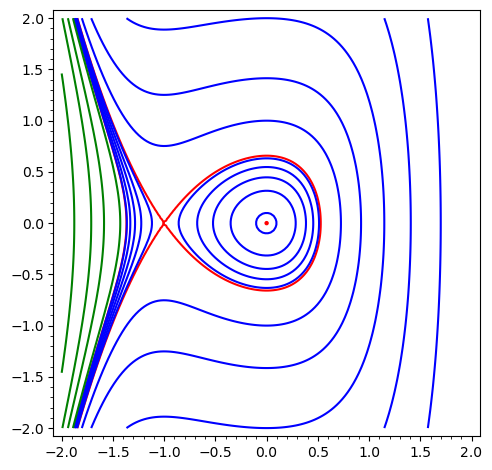

In [132]:
final_plot = saddle_plot + center_plot + sum(varius_plots) + point((0,0),color='red') + sum(varius_plots_2); final_plot

In [133]:
# final_plot.save('Ex1_plot_hamilt.pdf')

## Exercici 2

In [46]:
var('a b y t')
eqs2 = [-y+a*x+x^2, x+y^2+b*x*y]
ICS = [0,0.2,0]
a0 = 0.01
b0 = 4
stepl = 0.01
tfin = 10
sol2 = Odesol([x,y],t,eqs2,{a:a0, b : b0}, ics=ICS)
sol2.solve(step=stepl,tf=tfin)

In [47]:
sol2.set_ics([0,0.1,0])
sol2.solve(step=0.01,tf=6.5)

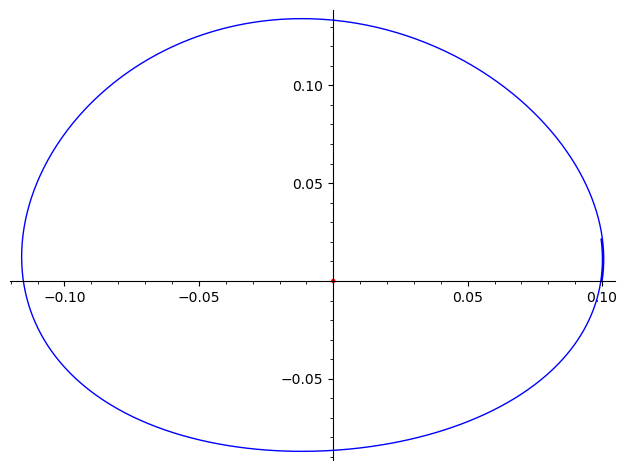

In [48]:
sol2.plot_xy() + point((0,0),color='red')

In [36]:
apl_desp = [desplacament(sol2,i,6,7) for i in srange(0.09,0.1,0.001)]

verbose 0 (3899: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 21 points.
verbose 0 (3899: plot.py, generate_plot_points) Last error message: 'Unable to compute f(0.1)'


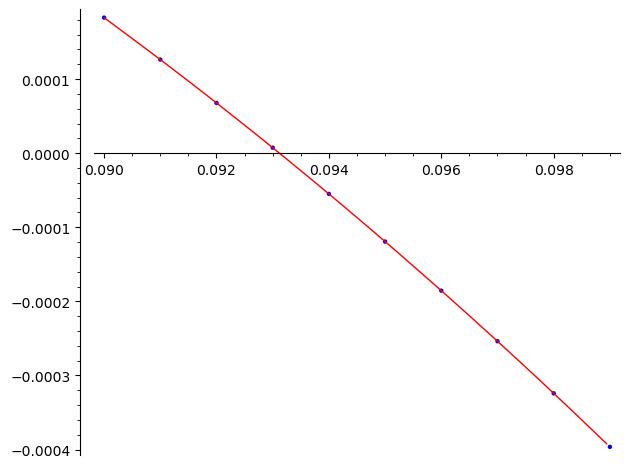

In [38]:
S = spline(apl_desp)
list_plot(apl_desp) + plot(S,0.09,0.1, color='red')

In [42]:
find_root(spline(apl_desp), 0.092,0.094)

0.09311972068158964

In [51]:
retorn(sol2,0.0931197,6,7,time=True)

[0.09311970024134987, 6.294053777138997]

In [141]:
# Hamiltonia per (a,b) = 0
F2 = (-x+y+1)*exp((x*y+1)/(x-y-1)+1)
F22 = -log(-x+y+1) + (x*y+1)/(x-y-1)
solve([-y+x^2, x+y^2], (x,y))

[[x == -1/2*I*sqrt(3) + 1/2, y == -1/2*I*sqrt(3) - 1/2], [x == 1/2*I*sqrt(3) + 1/2, y == 1/2*I*sqrt(3) - 1/2], [x == -1, y == 1], [x == 0, y == 0]]

In [162]:
n(log(3))

1.09861228866811

In [175]:
saddle_plot2 = implicit_plot(F22+log(3), (-2,2),(-2,2),color='red',zorder='10')
center_plot2 = implicit_plot(F22+1,(-2,2),(-2,2), color='red', zorder='10')
varius_plots2 = [implicit_plot(F22+i,(-2,2),(-2,2),zorder='20') for i in [1.12,1.2,1.5,2,4,8]]
varius_plots2_2 = [implicit_plot(F22+i,(-2,2),(-2,2),color='green',zorder='20') for i in [1.01,1.03,1.05,1.09]]
line_plot = implicit_plot(-x+y+1,(-2,2),(-2,2), color='black', zorder='10')

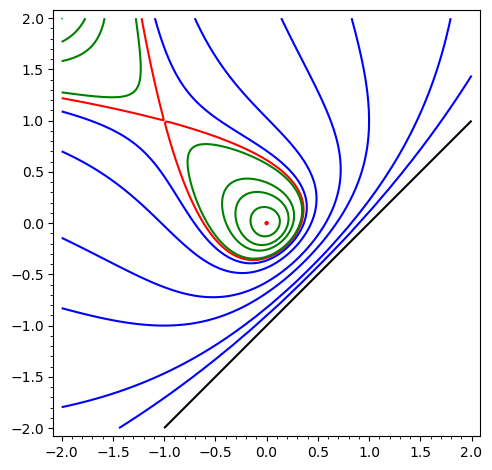

In [176]:
final_plot2 = saddle_plot2 + center_plot2 + sum(varius_plots2) + point((0,0),color='red') + sum(varius_plots2_2) + line_plot; final_plot2

In [178]:
# final_plot2.save("Ex2_plot_hamilt.pdf")

## Exercici 4

In [19]:
def f_1 (t, y, params):
    return [-y[1]-9*y[0]^2+4*y[0]*y[1]+params[0]*y[1]^2, y[0]+2*y[0]^2-7*y[0]*y[1]-2*y[1]^2]

T = ode_solver()
T.function = f_1
T.algorithm = 'rkf45'

In [47]:
var('x y b t')
eqs4 = [-y-9*x^2+4*x*y+b*y^2, x+2*x^2-7*x*y-2*y^2]

In [100]:
ICS = [0,-0.0948509,0.239919]
b0 = 9
stepl = 0.001
tfin = 10
sol4 = Odesol([x,y],t,eqs4,{b : b0}, ics=ICS)
sol4.solve(step=stepl,tf=tfin)

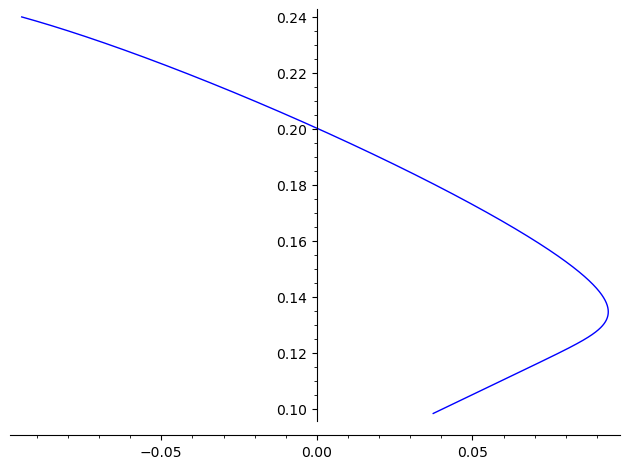

In [102]:
sol4.plot_xy()

In [90]:
sol4.sol[-4]

[1.997, -0.1261486809778327, 0.1442882416168821]

In [103]:
var('a b')
f(x) = a*x+b
find_fit([[i,j] for k,i,j in sol4.sol[-10:]],f)

[a == 0.5328938861958672, b == 0.07841218091701521]

In [104]:
eqs4_1=[-y-9*x^2+4*x*y+4*y^2, x+2*x^2-7*x*y-2*y^2]
eqs4_2=[-y-9*x^2+4*x*y+9*y^2, x+2*x^2-7*x*y-2*y^2]

In [107]:
factor((2*x*eqs4_1[0]+2*y*eqs4_1[1]).simplify_full())

-2*(3*x^2 - 3*x*y + 2*y^2)*(3*x + y)

In [108]:
factor((2*x*eqs4_2[0]+2*y*eqs4_2[1]).simplify_full())

-18*x^3 + 12*x^2*y + 4*x*y^2 - 4*y^3

In [112]:
var('a1 a2 a3 b1 b2 b3')
f = a1*x+a2*y+a3
k = b1*x+b2*y+b3
expand((diff(f,x)*eqs4_2[0]+diff(f,x)*eqs4_2[1]).simplify_full())

-7*a1*x^2 - 3*a1*x*y + 7*a1*y^2 + a1*x - a1*y

## Exercici 5

In [116]:
var('x y')
eqs5 = [-3*x*(28*x**2 - 46*x*y + 56*y**2 - x - 122*y + 28),y*(126*x**2 - 92*x*y + 42*y**2 - 3*x - 122*y + 42)]

In [117]:
sols5_totes = solve(eqs5, (x,y),solution_dict=True)
sols5_totes

[{x: 0, y: 0},
 {x: -1/56*I*sqrt(3135) + 1/56, y: 0},
 {x: 1/56*I*sqrt(3135) + 1/56, y: 0},
 {x: 0, y: -1/42*sqrt(1957) + 61/42},
 {x: 0, y: 1/42*sqrt(1957) + 61/42},
 {x: 2, y: 3},
 {x: 0.05678952031290685 + 0.3582878061612404*I,
  y: 0.2125202696991953 - 0.02699585660665859*I},
 {x: 0.05678952031290685 - 0.3582878061612404*I,
  y: 0.2125202696991954 + 0.0269958566066586*I},
 {x: -0.2408317885064883, y: 1.659355080614923}]

In [118]:
sols5 = [sols5_totes[0], sols5_totes[4],sols5_totes[5]]
sols5

[{x: 0, y: 0}, {x: 0, y: 1/42*sqrt(1957) + 61/42}, {x: 2, y: 3}]

In [119]:
J5 = jacobian(eqs5, (x,y)); J5.simplify_full()

[-252*x^2 + 6*(46*x + 61)*y - 168*y^2 + 6*x - 84                       138*x^2 - 336*x*y + 366*x]
[                        3*(84*x - 1)*y - 92*y^2  126*x^2 - 4*(46*x + 61)*y + 126*y^2 - 3*x + 42]

In [120]:
J5.subs(sols5[0])

[-84   0]
[  0  42]

In [121]:
J5.subs(sols5[1]).eigenvalues()

[61/21*sqrt(1957) + 1957/21, -61/21*sqrt(1957) - 1957/21]

In [132]:
J5.subs(sols5[2])

[ 162 -732]
[ 675 -162]

In [122]:
J5.subs(sols5[2]).eigenvalues()

[-684*I, 684*I]

In [123]:
factor(684)

2^2 * 3^2 * 19

In [169]:
eqs5_shift = [(1/684*eq.subs(x=x+2,y=y+3)).simplify_full().expand() for eq in eqs5]; eqs5_shift

[-7/57*x^3 + 23/114*x^2*y - 14/57*x*y^2 - 29/228*x^2 - 5/38*x*y - 28/57*y^2 + 9/38*x - 61/57*y,
 7/38*x^2*y - 23/171*x*y^2 + 7/114*y^3 + 21/38*x^2 - 17/228*x*y + 2/19*y^2 + 75/76*x - 9/38*y]

In [170]:
J5_shift = jacobian(eqs5_shift, (x,y)).subs(x=0,y=0); J5_shift

[  9/38 -61/57]
[ 75/76  -9/38]

In [183]:
J5_shift.eigenvectors_left()[1][1][0]

(1, 76/75*I - 6/25)

In [179]:
F5 = x*y^2*(84*x^2-92*x*y+84*y^2-3*x-244*y+84)

In [180]:
F5.subs(x=2,y=3)

-2052

In [181]:
F5.subs(x=0,y=0)

0

In [217]:
saddle_plot5 = implicit_plot(F5, (-0.1,4),(-0.1,4),color='red',zorder='10')
center_plot5 = implicit_plot(F5+2052,(-.1,4),(-.1,4), color='red', zorder='10')
varius_plots5 = [implicit_plot(F5+i,(-.1,4),(-.1,4),zorder='20') for i in srange(205.2,2052.1, 2052/10)]
varius_plots5_2 = [implicit_plot(F5-i,(-.1,4),(-.1,4),zorder='20',color='green') for i in srange(205.2,2052.1, 2052/5)]
line_plot5 = implicit_plot(y, (x,-.1,4),(y,-.1,4),color='red',zorder='10')

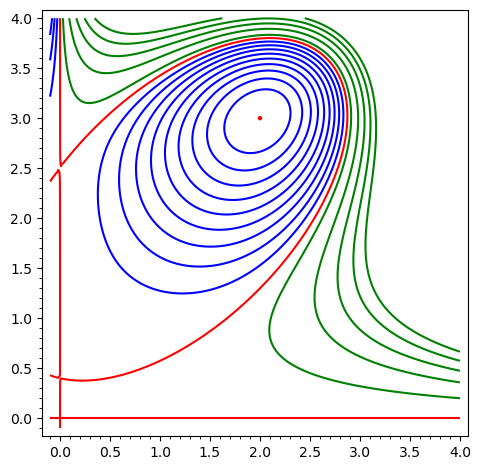

In [218]:
final_plot5 = saddle_plot5 + center_plot5 + sum(varius_plots5) + point((2,3),color='red') + sum(varius_plots5_2) + line_plot5; final_plot5

In [219]:
final_plot5.save("Ex5_plot_hamilt.pdf")

## Exercici 6

In [40]:
var('b1 b2')
eqs6 = [y, b1+b2*x+x^2+x*y]
eqs6_0 = [y, b2*x+x^2+x*y]

In [41]:
sols6 = solve(eqs6, (x,y), solution_dict=True); sols6

[{x: -1/2*b2 - 1/2*sqrt(b2^2 - 4*b1), y: 0},
 {x: -1/2*b2 + 1/2*sqrt(b2^2 - 4*b1), y: 0}]

In [42]:
sols6_0 = solve(eqs6_0, (x,y), solution_dict=True); sols6_0

[{x: 0, y: 0}, {x: -b2, y: 0}]

In [43]:
J6 = jacobian(eqs6, (x,y)); J6

[           0            1]
[b2 + 2*x + y            x]

In [45]:
show(J6.subs(sols6_0[0]).eigenvalues())

[-sqrt(b2), sqrt(b2)]

In [52]:
J6.subs(sols6_0[1]).eigenvalues()

[-1/2*b2 - 1/2*sqrt(b2^2 - 4*b2), -1/2*b2 + 1/2*sqrt(b2^2 - 4*b2)]

In [50]:
latex(J6.subs(sols6_0[1]))

\left(\begin{array}{rr}
0 & 1 \\
-b_{2} & -b_{2}
\end{array}\right)